# KMeans Clustering by Contour Length

Import necessary library

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pathlib import Path
import pandas as pd
from scipy import stats

Change the "test" to your folder path, change the "test_file" to your file name without suffix

In [15]:
folder_name = Path(r'test')
file_name = 'test_file'


filename_txt = file_name+".txt"
df = pd.read_csv(folder_name/filename_txt, delim_whitespace=True, header=0)
print(df.head())
print(df.columns)

   cycle_flag  Force(pN)  step_time(s)  step_size(nm)  contour_length(nm)  \
0         1.0  16.805236       341.984       14.18550           20.190136   
1         2.0  45.301493      1232.503       16.05702           19.438032   
2         5.0  10.698606      2171.848       13.82164           22.342275   
3         2.0  11.409490       882.329       11.52640           18.242718   
4         2.0  12.226628       890.231       13.09754           20.288349   

         date_bead  
0  20240814_bead01  
1  20240814_bead02  
2  20240814_bead02  
3  20240814_bead03  
4  20240814_bead03  
Index(['cycle_flag', 'Force(pN)', 'step_time(s)', 'step_size(nm)',
       'contour_length(nm)', 'date_bead'],
      dtype='object')


Change "force_feature" to your force column name.(Case sensitive)

Change "test_feature" to your contour length column name.(Case sensitive)

Select the number of clusters you want to group.(An positive integer)

C:\Users\Yunxin\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yunxin\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Yunxin\AppData\Local\Temp\ipykernel_19584\3483438678.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Cluster'] = kmeans.fit_predict(df_no_outliers[[feature_b]])
C:\Users\Yu

   OrderedCluster      Force  Contour_Length
0               1  14.604204       10.989161
1               2  20.054276       19.435877
2               3  22.518437       34.562693


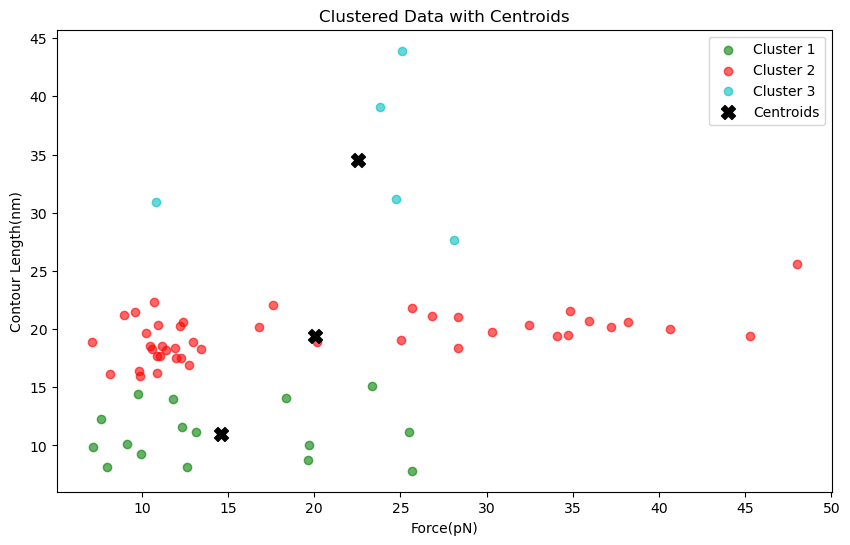

In [16]:
# Step 1: Select the relevant columns
feature_a = 'force_feature'
feature_b = 'test_feature'
num_clusters = 3

# Step 2: Remove outliers from Feature B using Z-score method
z_scores = np.abs(stats.zscore(df[feature_b]))
threshold = 5
df_no_outliers = df[z_scores < threshold]

# Step 3: Apply k-means clustering on Feature B
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
df_no_outliers['Cluster'] = kmeans.fit_predict(df_no_outliers[[feature_b]])

# Step 4: Calculate the centroids of the clusters
centroids = kmeans.cluster_centers_.flatten()

# Step 5: Order the clusters by the centroids of Feature B
sorted_centroids_indices = np.argsort(centroids)
label_map = {old_label: new_label for new_label, old_label in enumerate(sorted_centroids_indices)}
df_no_outliers['OrderedCluster'] = df_no_outliers['Cluster'].map(label_map)

df_no_outliers['Cluster'] = df_no_outliers['Cluster']+1
df_no_outliers['OrderedCluster'] = df_no_outliers['OrderedCluster']+1

# Step 6: Calculate the average of Feature A for each new ordered cluster
feature_a = 'Force(pN)'
clustered_data = df_no_outliers.groupby('OrderedCluster').agg(
    Force=(feature_a, 'mean'),
    Contour_Length=(feature_b, 'mean')  # Approximate centroids using mean of Feature B
).reset_index()

# Step 7: Add the exact centroids of Feature B
ordered_centroids = centroids[sorted_centroids_indices]

# Display the result
print(clustered_data)

# Step 8: Plot the clustered data
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm']

for cluster in range(1,num_clusters+1):
    cluster_data = df_no_outliers[df_no_outliers['OrderedCluster'] == cluster]
    plt.scatter(cluster_data[feature_a], cluster_data[feature_b], 
                label=f'Cluster {cluster}', c=colors[cluster % len(colors)], alpha=0.6)
    
# Plot centroids
plt.scatter(clustered_data['Force'], clustered_data['Contour_Length'], 
            color='black', marker='X', s=100, label='Centroids')

plt.title('Clustered Data with Centroids')
plt.xlabel('Force(pN)')
plt.ylabel('Contour Length(nm)')
plt.legend()
plt.show()

from scipy.optimize import fsolve
step_size = []
for i in range(len(clustered_data)):
    def func(x):
        return (x + 1 / (4 * (1 - x) ** 2) - 0.25) * 4.1 / 0.8 - F  # WLC
    F = clustered_data['Force'][i]
    sol = fsolve(func, 0.8)
    step_size.append(clustered_data['Contour_Length'][i]*sol[0])
clustered_data['Step_Size'] = step_size


The clustered data with label and centroids of your clusters will be saved as your filename with suffix in txt format, in the same folder as the folder you input in the begining.

In [17]:
# Step 3: Save DataFrame with cluster labels
save_cluster = file_name+'_clustered_data_bycl.txt'
df_no_outliers.to_csv(folder_name/save_cluster, sep='\t', index=False)

# Step 4: Save cluster labels and centroids
save_centroids = file_name+'_Centroids_bycl.txt'
clustered_data.to_csv(folder_name/save_centroids, sep='\t', index=False)